In [1]:
import pandas as pd
import numpy as np
import csv
import math
from matplotlib import pyplot as plt
from model_estimation import estimate_model_performance
from preprocessing_utils import EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder, MONTH_COL, standardize_data
from sklearn.model_selection import train_test_split
from data_completeness import fill_special_cols, fill_duration_zeros, impute_knn_missing_data, fill_total_duration
from remove_outliers import impute_zscore_test

from dimension_reduction import transform_data_with_pca
from data_completeness import fill_missing_data
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

Original amount of rows: 10479
New amount of rows: 9355


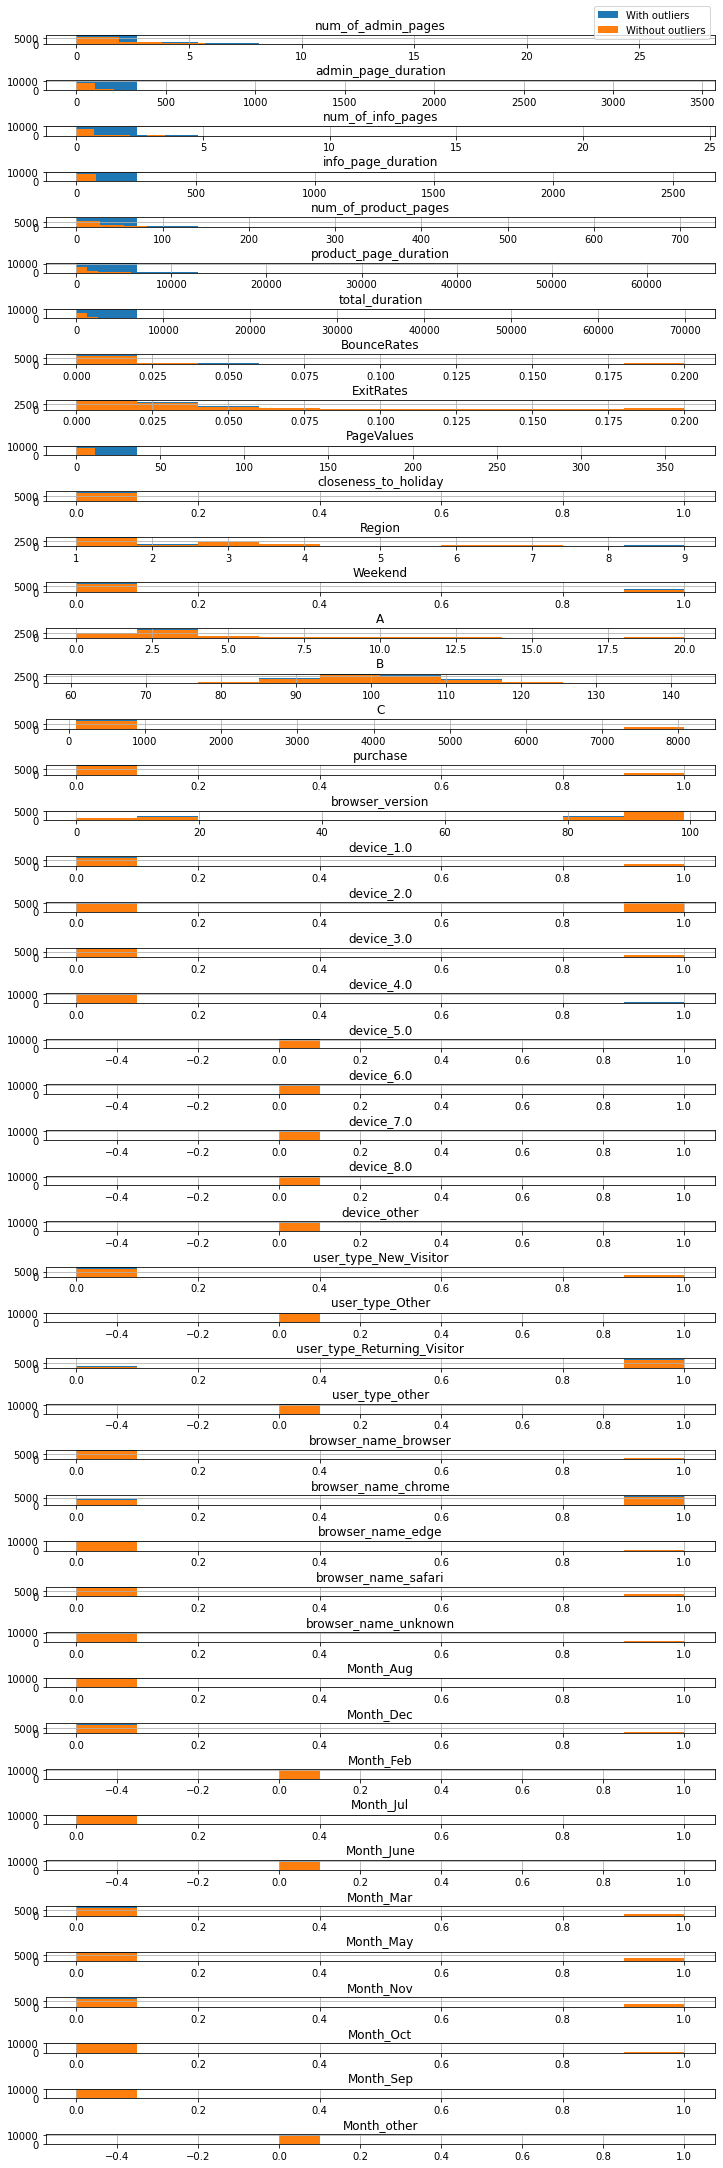

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

clean_train_data = standardize_data(train_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.DUMMY)
orig = clean_train_data.copy()
filled_train_data = fill_missing_data(clean_train_data)
filled_train_data.pop('id') # TODO - make sure it is somewhere in the code

Z_SCORE_THRESHOLD = 5.5
train_data_wo_outliers = impute_zscore_test(filled_train_data, Z_SCORE_THRESHOLD)

In [3]:
y = train_data_wo_outliers.pop('purchase')
X = train_data_wo_outliers

# Random Forest

Before running the predictions, we will investigate the different hyperparameters focusing on 3 different ones:
1. N Estimators - number of trees in the forest.
2. Max depth - depth levels of each tree
3. Min samples required for a split in the tree (TODO - decide if it a useful metric!)

We will use Grid Search as we learned in class to compare between the different parameter values and choose the best score according the desired metric for this project - AUC.
We will then run the model to retrieve 2 cool results:
- The model estimation as shown in previous model_selection
- Feature importance - in random forest we also know the importance and the "weight" of each feature, similar to the way we do in Linear Regression. We will present the best features and compare them to those shown previously. We expect them to match on key features.

In [7]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.8, random_state = 42)
pca_X_train, pca_X_validate = transform_data_with_pca(X_train, X_validate, explained_variance=0.99)

parameters = {
    # TODO - fix estimator
    'n_estimators': range(20, 75, 5), # Limited subset not to exceed the runtime limitation
    'max_depth': range(3, 15),
    'min_samples_split': range(2, 5)
}
clf = RandomForestClassifier()
gscv = GridSearchCV(clf, parameters, scoring='roc_auc', error_score='raise')
gscv.fit(X, y)

#TODO: print requested values
best_params = gscv.best_params_
best_score = gscv.best_score_
print(f'Best Params: {best_params} \n')
print(f'Train AUC score for best params: {best_score}')

Best Params: {'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 40} 

Train AUC score for best params: 0.9101005701615458


0.89 accuracy with a standard deviation of 0.01
-0.11 MSE with a standard deviation of 0.01


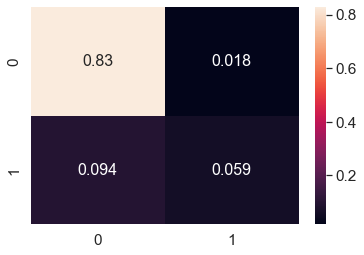

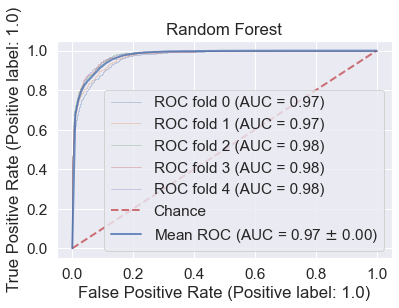

<Figure size 720x720 with 0 Axes>

In [4]:
# Running the algorithm on non-reduced dataset - without dimension reduction!
best_params = {'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 40}
clf = RandomForestClassifier(**best_params)
estimate_model_performance(clf, 'Random Forest', X, y, 5)

In [ ]:
from sklearn.metrics import roc_auc_score

# Running the model on data transformed with PCA with variance 0.99
clf.fit(pca_X_train, y_train)
pca_test_predictions = clf.predict_proba(pca_X_validate)
auc = roc_auc_score(y_validate, pca_test_predictions[:, 1])
print(f"AUC: {auc}")
estimate_model_performance(clf, 'Random Forest', pd.DataFrame(pca_X_validate), pd.DataFrame(y_validate), 5)

The algorithm yields very good results! Mean ROC AUC score of 0.95 is the best score we've yielded so far.
The reason for it can be the grid search that optimized its parameter in the best manner, or the way the data itself behaves.<br><br>

### Feature importance
The random forest algorithm also contains a feature importance feature that will help us learn which features were most important for this score (it will only work with :

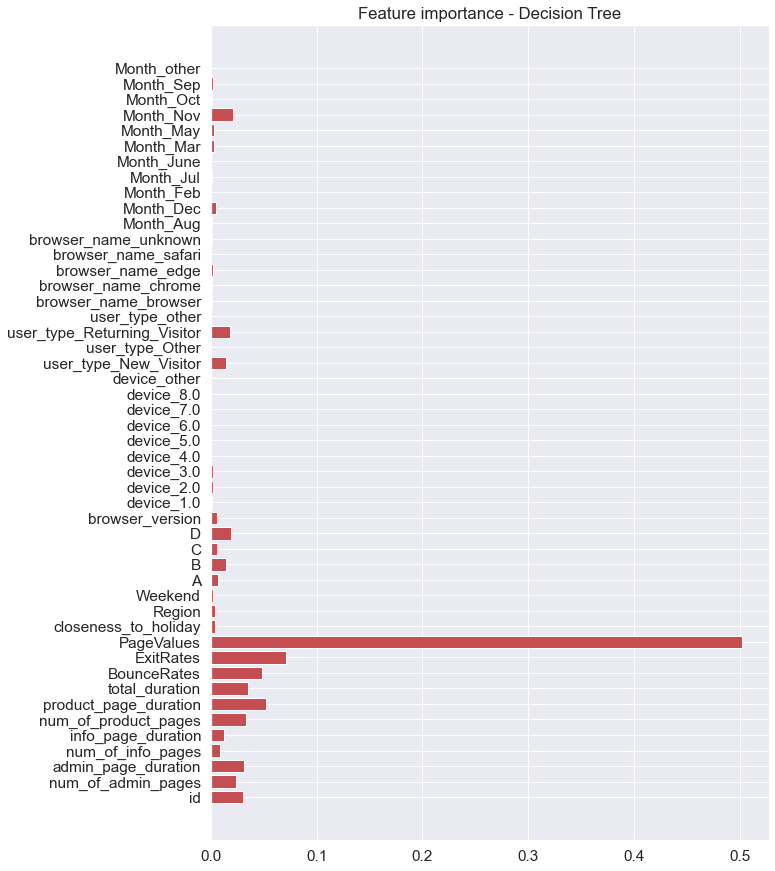

In [18]:
plt.figure(figsize=(10,15))
plt.barh(clf.feature_names_in_, clf.feature_importances_, color='r')
# plt.xticks(clf.feature_names_in_, rotation=90)
plt.title("Feature importance - Decision Tree");

From the graph above we can learn very interesting information:
- Out of all the months, it seems like December and mainly November has importance. It is very easy to explain as those months are closest to Christmas, which is a holiday that involves a lot of gifts shopping.
- Page Values seems like the most valuable column, by far. This one also makes sense, as the "value" is affected by how the sessions ended (purchase or not).
- Devices and browsers have very low impact, close to none.
- The information about the different pages and their session duration is the type of data to contain the most interest by the model.